In [3]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

In [4]:
# random rottaion matrix
def random_rotation_matrix():
    R = np.random.rand(3, 3)
    Q, R = np.linalg.qr(R)
    R = np.diag(np.sign(np.diag(R)))
    if np.linalg.det(R) < 0:
        R[0, 0] *= -1
    return np.dot(Q, R)


R = random_rotation_matrix()
print(np.linalg.det(R))

unit_vec = np.array([1, 2, 3]) / np.linalg.norm(np.array([1, 2, 3]))
unit_vec

d = 10
rot_vec = (R @ unit_vec.reshape(3, 1)) * d

assert np.allclose(np.linalg.norm(rot_vec), d)

0.9999999999999998


In [113]:
# x = [p,v,a,bias_a,d_bias_a]
# u = [a]
# y = [p]

A = [[0, 1, 0],
     [0, 0, 1],
     [0, 0, 0]]
A = np.array(A)
# add bias term
A = np.concatenate([A, np.zeros((3, 2))], axis=1)
A = np.concatenate([A, np.zeros((2, 5))], axis=0)
A[1, 3] = 1
A[2, 4] = 1
A

C = [[1, 0, 0, 0, 0],
     [0, 0, 1, 0, 0]]

# generate trajectory p(t)
end = 120
samples = end*200
t = np.linspace(0, end, samples)
p = np.sin(t)
v = np.cos(t)
a = -np.sin(t)
a_bias = np.arange(samples) / samples * .01
ya = a + a_bias + 0.1*np.random.randn(samples)
yp = p + 0.1*np.random.randn(samples)

dt = t[1] - t[0]
Ad = la.expm(A*dt)
Ad

a_variance = 0.01
p_variance = 0.01

In [121]:
# Define the system matrices
F = Ad

H = np.array(C)

Q = np.array([[dt**4/4, dt**3/2, dt**2/2, 0, 0],
              [dt**3/2, dt**2, dt, 0, 0],
              [dt**2/2, dt, 1, 0, 0],
              [0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0],]) * a_variance

R = np.array([[p_variance, -0.01457685],
              [-0.01457685,  a_variance],])

# Initial state estimate
x_hat = np.array([[0], [1], [0], [0], [0]])

# Initial error covariance
P = np.diag([.1, .1, 10, 100, 1000])

record = np.zeros((len(p), 5))
pos_modulo = int(np.ceil(0.033/dt))
# Kalman Filter loop
for i in range(len(p)):
    # Predict step
    x_hat = F @ x_hat
    P = F @ P @ F.T + Q

    # Position update
    if i % pos_modulo == 0:
        Hp = H[0, :].reshape(1, 5)
        K = P @ Hp.T @ np.linalg.inv(Hp @ P @ Hp.T + R[0, 0])
        x_hat = x_hat + K @ (yp[i] - Hp @ x_hat)
        P = (np.eye(5) - K @ Hp) @ P

    # Acceleration update
    Ha = H[1, :].reshape(1, 5)
    K = P @ Ha.T @ np.linalg.inv(Ha @ P @ Ha.T + R[1, 1])
    x_hat = x_hat + K @ (ya[i] - Ha @ x_hat)
    P = (np.eye(5) - K @ Ha) @ P

    # # mutual update
    # Hm = H
    # K = P @ Hm.T @ np.linalg.inv(Hm @ P @ Hm.T + R)
    # x_hat = x_hat + K @ (np.array([[yp[i]], [ya[i]]]) - Hm @ x_hat)
    # P = (np.eye(3) - K @ Hm) @ P

    record[i, :] = x_hat.T

In [122]:
# print error statistics of estimation
print("Error statistics (RMSE):")
print("p:", np.sqrt(np.mean((record[:, 0] - p)**2)))
print("v:", np.sqrt(np.mean((record[:, 1] - v)**2)))
print("a:", np.sqrt(np.mean((record[:, 2] - a)**2)))

Error statistics (RMSE):
p: 0.05002104558199272
v: 0.20374287663609789
a: 0.06728212356746918


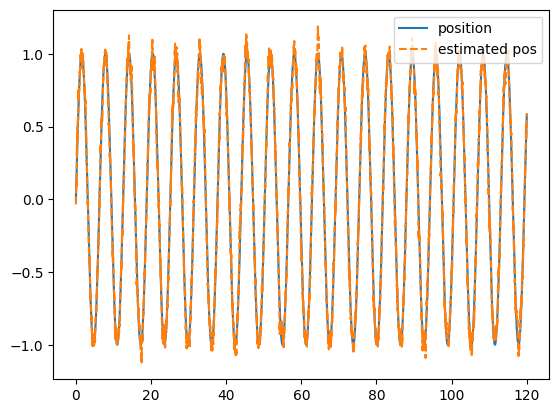

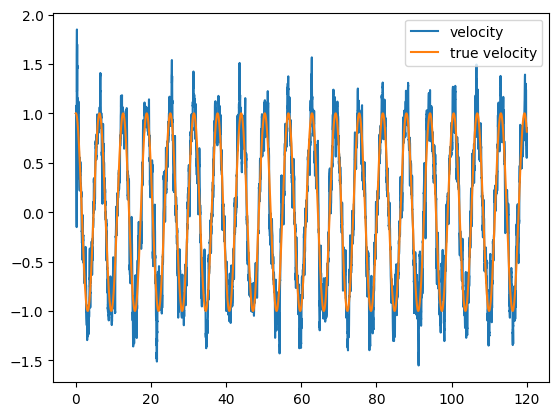

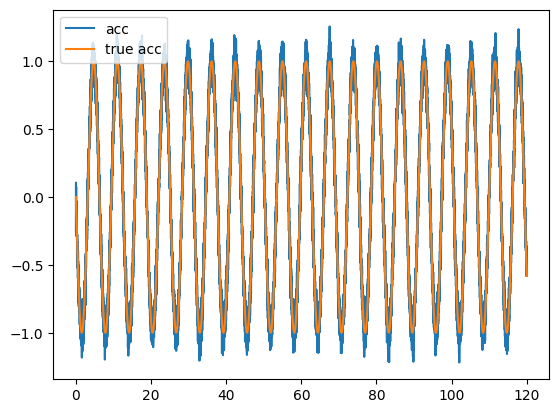

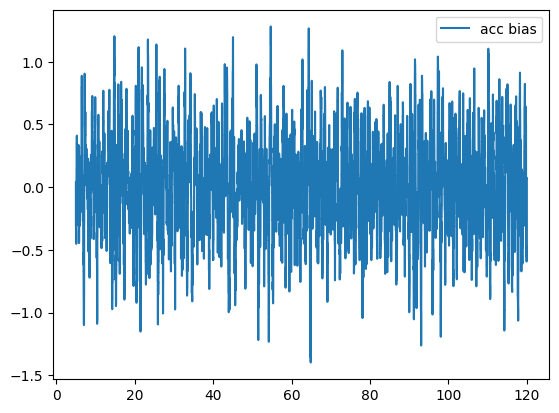

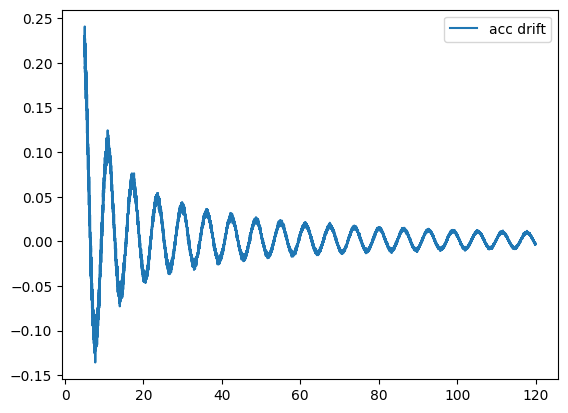

In [123]:
# plt.figure(dpi=200)
plt.plot(t,p, label='position')
plt.plot(t,record[:, 0], label='estimated pos', linestyle='dashed')
# plt.scatter(np.arange(0, len(p), end), yp[::end], label='measured', marker='x', c='g')
plt.legend()
# velocity
plt.figure()
plt.plot(t, record[:, 1], label='velocity')
plt.plot(t, v, label='true velocity')
plt.legend()
plt.figure()
plt.plot(t, record[:, 2], label='acc')
plt.plot(t, a, label='true acc')
plt.legend()
plt.figure()
plt.plot(t[1000:], record[1000:, 3], label='acc bias')
plt.legend()
plt.show()
plt.figure()
plt.plot(t[1000:], record[1000:, 4], label='acc drift')
plt.legend()
plt.show()


In [120]:
a_bias[-1]

0.009999583333333333

In [ ]:
# ### from 1d notebook

# # %%
# import control as ct
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.linalg as la

# # %%
# # x = [p,v,b_a]
# # u = [a]
# # y = [p]

# A = [[0, 1, 0],
#      [0, 0, -1],
#      [0, 0, 0]]
# B = [[0],
#      [1],
#      [0]]
# C = [[1, 0, 0]]
# D = [[0]]

# sys = ct.ss(A, B, C, D)
# obs = ct.obsv(sys.A, sys.C)
# print("Obs: ", np.linalg.matrix_rank(obs))

# # generate trajectory p(t)
# end = 60
# samples = end*200
# t = np.linspace(0, end, samples)
# p = np.sin(t)
# v = np.cos(t)
# a_bias = 0.1
# a_noise = np.random.randn(samples)
# a = -np.sin(t) + a_bias + a_noise
# yp = p + 0.1*np.random.randn(samples)
# # yp = np.vstack([yp, v + 0.05*np.random.randn(samples)])

# comb = np.concatenate([A, B], axis=1)
# comb = np.concatenate([comb, np.zeros((1, 4))], axis=0)

# dt = t[1] - t[0]
# print(dt)
# la.expm(comb*dt)
# Ad = la.expm(comb*dt)[:3, :3]
# Bd = la.expm(comb*dt)[:3, 3:]
# Ad, Bd

# # %%
# plt.plot(t, yp)
# samples * dt

# # %%
# # Define the system matrices
# F = Ad

# H = np.array(C)

# # Process noise covariance
# Q = np.diag([1, 1, 0])

# # Measurement noise covariance
# R = np.diag([[1]])

# # Initial state estimate
# x_hat = np.array([[0], [1], [0]])

# # Initial error covariance
# P = np.diag([1, 100, 1000])

# record = np.zeros((len(p), 3))

# pos_modulo = int(np.ceil(0.033/dt)) * 10

# # Kalman Filter loop
# for i in range(len(p)):
#     # Predict step
#     x_hat = F @ x_hat + Bd * a[i]
#     P = F @ P @ F.T + Q

#     # Update step
#     if i % pos_modulo == 0 and i < 5000:
#         K = P @ H.T @ np.linalg.inv(H @ P @ H.T + R)
#         x_hat = x_hat + K @ (yp[i] - H @ x_hat)
#         P = (np.eye(3) - K @ H) @ P

#     record[i, :] = x_hat.T

# # plt.figure(dpi=200)
# plt.plot(t,p, label='position')
# plt.plot(t,record[:, 0], label='estimated pos', linestyle='dashed')
# # plt.scatter(np.arange(0, len(p), end), yp[::end], label='measured', marker='x', c='g')
# plt.legend()
# # velocity
# plt.figure()
# plt.plot(t, record[:, 1], label='velocity')
# plt.plot(t, v, label='true velocity')
# plt.legend()
# plt.figure()
# plt.plot(record[:, 2], label='bias')
# plt.plot(np.ones(len(record))*a_bias, label='true bias')
# plt.legend()

# # %%
# # x = [p,v,b_a,b_a_dot]
# # u = [a]
# # y = [p]

# A = [[0, 1, 0, 0],
#      [0, 0, -1, 0],
#      [0, 0, 0, 1],
#      [0, 0, 0, 0]]
# B = [[0],
#      [1],
#      [0],
#      [0]]
# C = [[1, 0, 0, 0]]
# D = [[0]]
# n = 4
# dt = 0.01

# sys = ct.ss(A, B, C, D)
# obs = ct.obsv(sys.A, sys.C)
# print("Obs: ", np.linalg.matrix_rank(obs))

# # generate trajectory p(t)
# end = 30
# samples = end*100
# p = np.sin(np.linspace(0, end, samples))
# v = np.cos(np.linspace(0, end, samples))
# # generate slowly varying bias, basically a line with a slope
# a_bias = np.linspace(0, .3, samples)
# slope = (a_bias[2] - a_bias[1]) / dt
# # a_bias = 0.1*np.sin(np.linspace(0, end, samples)) + 0.3
# # a_bias_dot = 0.1*np.cos(np.linspace(0, end, samples))
# a_noise = 0.2*np.random.randn(samples)
# a = -np.sin(np.linspace(0, end, samples)) + a_bias + a_noise
# yp = p + 0.05*np.random.randn(samples)

# comb = np.concatenate([A, B], axis=1)
# comb = np.concatenate([comb, np.zeros((1, comb.shape[1]))], axis=0)

# la.expm(comb*dt)
# Ad = la.expm(comb*dt)[:n, :n]
# Bd = la.expm(comb*dt)[:n, n:]

# # Define the system matrices
# F = Ad

# H = np.array(C)

# # Process noise covariance
# Q = np.diag([1, 1, 0, 0])

# # Measurement noise covariance
# R = np.array([[0.05]])

# # Initial state estimate
# x_hat = np.array([[0], [1.0], [0], [0]])

# # Initial error covariance
# P = np.diag([1, 1, 1000, 10])

# record = np.zeros((len(p), n))

# # Kalman Filter loop
# for i in range(len(p)):
#     # Predict step
#     x_hat = F @ x_hat + Bd * a[i]
#     P = F @ P @ F.T + Q

#     # Update step
#     if i % end == 0:
#         K = P @ H.T @ np.linalg.inv(H @ P @ H.T + R)
#         x_hat = x_hat + K @ (yp[i] - H @ x_hat)
#         P = (np.eye(n) - K @ H) @ P

# #     print("Estimated position:", x_hat[0, 0])
# #     print("Estimated velocity:", x_hat[1, 0])
# #     print("Estimated bias:", x_hat[2, 0])
# #     print("Estimated bias drift:", x_hat[3, 0])
# #     print("p error:", np.abs(x_hat[0, 0] - p[i]))

#     record[i, :] = x_hat.T
# #     print()

# plt.figure(dpi=200)
# plt.plot(p, label='true')
# plt.plot(record[:, 0], label='estimated', linestyle='dashed')
# # plt.scatter(np.arange(0, len(p), end), yp[::end], label='measured', marker='x', c='g')
# plt.legend()
# # velocity
# plt.figure()
# plt.plot(record[:, 1], label='velocity')
# plt.plot(v, label='true velocity')
# plt.legend()
# plt.figure()
# plt.plot(record[:, 2], label='bias')
# plt.plot(np.ones(len(record))*a_bias, label='true bias')
# plt.legend()
# plt.figure()
# plt.plot(record[:, 3], label='bias drift')
# plt.plot(np.ones(samples)*slope, label='true bias drift')
# plt.legend()

In [ ]:
# from 3D notebook

# # %%
# import control as ct
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.linalg as la
# np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

# # %%
# # Define the system matrices
# A = np.block([[np.zeros((3, 3)), np.eye(3), np.zeros((3, 3))],
#               [np.zeros((3, 3)), np.zeros((3, 3)), -np.eye((3))],
#               [np.zeros((3, 3)), np.zeros((3, 3)), np.zeros((3, 3))]])
# B = np.block([[np.zeros((3, 3))],
#               [np.eye(3)],
#               [np.zeros((3, 3))]])
# C = np.block([[np.eye(3), np.zeros((3, 6))]]) # the z is assumed to come from altimeter/barometer
# D = 0

# sys = ct.ss(A, B, C, D)
# obs = ct.obsv(sys.A, sys.C)
# print("Obs: ", np.linalg.matrix_rank(obs))

# A.shape,B.shape
# comb = np.block([[A, B], [np.zeros((12-A.shape[0], 12))]])
# dt = 0.005
# dMexp = la.expm(comb*dt)
# Ad = dMexp[:A.shape[0], :A.shape[0]]
# Bd = dMexp[:A.shape[0], A.shape[0]:]
# assert Ad.shape == A.shape
# assert Bd.shape == B.shape

# # %%
# # generate trajectory p(t)
# end = 5
# samples = end*100
# np.random.seed(0)
# p = np.vstack((np.sin(np.linspace(0, end, samples)),
#                np.cos(np.linspace(0, end, samples)),
#                np.ones(samples)))  # delta p
# v = np.vstack((np.cos(np.linspace(0, end, samples)),
#                -np.sin(np.linspace(0, end, samples)),
#                np.zeros(samples)))  # delta v
# a_bias = np.array([[0.1, 0.2, 0.3]]).T
# a_noise = 0.2*np.random.randn(3, samples)
# a = np.vstack((-np.sin(np.linspace(0, end, samples)),
#                -np.cos(np.linspace(0, end, samples)),
#                np.zeros(samples),)) + a_bias + a_noise
# yp = p + 0.05*np.random.randn(3, samples)

# # %%
# # Define the system matrices
# F = Ad

# H = np.array(C)

# # Process noise covariance
# Q = np.diag([1, 1, 1, 1, 1, 1, 0, 0, 0])

# # Measurement noise covariance
# R = np.diag([0.05, 0.05, 0.05])

# # Initial state estimate
# x_hat = np.zeros((9, 1))

# # Initial error covariance
# P = np.diag([10, 10, 10, 10, 10, 10, 1000, 1000, 1000])

# record = np.zeros((len(p[0]), 9))

# # Kalman Filter loop
# for i in range(len(p[0])):
#     # Predict step
#     x_hat = F @ x_hat + Bd @ a[:, i].reshape(-1, 1)
#     P = F @ P @ F.T + Q

#     # Update step
#     if i % 6 == 0:
#         K = P @ H.T @ np.linalg.inv(H @ P @ H.T + R)
#         x_hat = x_hat + K @ (yp[:, i].reshape(-1, 1) - H @ x_hat)
#         P = (np.eye(9) - K @ H) @ P
#     record[i, :] = x_hat.T

# plt.plot(p[0], p[1], label='true')
# plt.plot(record[:, 0], record[:, 1], label='estimated', linestyle='dashed')
# plt.legend()
# plt.figure()
# plt.plot(np.arange(len(p[0])), p[2], label='true height')
# plt.plot(np.arange(len(p[0])), record[:, 2], label='estimated height')
# plt.figure()
# plt.plot(record[:, -3:], label='estimated bias')
# plt.plot((a_bias*np.ones(len(record))).T, label='true bias')
# plt.legend()

# # %%
# rmse = np.sqrt(np.mean((p[:3, :].T - record[:, :3])**2, axis=0))
# rmae = np.mean(np.abs(p[:3, :].T - record[:, :3]), axis=0)
# rmse, rmae